# Apply PCI to simulated data 
## Investigate the impact of individual noise contributions

Here we apply PCI to data simulated via the LISA Simulation Suite, following the simulation scripts.

The simulated datasets are 3 days long. PCI is applied to 12 hours of data, with 4 hours of skipped data at the beginning of the simulation.

We need the following simulated datasets:
- full simulation noise dataset (including laser noise and secondary noises), with filename ending in `_measurements_4Hz.h5`
- secondary noises dataset, with filename ending in `_noise_sec_4Hz.h5`

# 0. Installations and data generation

The package dependencies are:

    pip install numpy scipy sympy h5py matplotlib xarray h5py scikit-learn
    pip install lisaconstants
    pip install lisainstrument
    pip install lisagwresponse
    pip install pytdi
    pip install backgrounds

and after installation, the data generation step is performed by running the simulation scripts: 

In [1]:
!pwd

/Users/ecastel2/Documents/virtual-envs/software-install/pcipy/notebooks


In [2]:
#!python ../simulation/noise_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2 --baseline --individual

In [12]:
!python ../simulation/signal_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2

INFO:root:Data size: 1036800
INFO:root:Data duration: 72.0 hours
INFO:lisagwresponse.response:Initializing gravitational-wave response (lisagwresponse verion 2.4)
INFO:lisagwresponse.response:Reading orbits from file '/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/keplerian-orbits.h5'
INFO:lisagwresponse.response:Computing spline interpolation for orbits
INFO:lisagwresponse.response:Computing spline interpolation for gravitational-wave strain
INFO:lisagwresponse.response:Reading sampling parameters from file '/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-28_17h02_gw_measurements_4Hz.h5'
INFO:lisagwresponse.response:New GW file with version 2.4
INFO:lisagwresponse.response:Setting global metadata
INFO:lisagwresponse.response:Computing spline interpolation for TPS times
INFO:lisagwresponse.response:Computing gravitational-wave response for links [12 23 31 13 32 21]
INFO:lisagwresponse.response:Writing link response datasets
INFO:lisagwresponse.respo

In [4]:
#!python ../simulation/all_sky_signal_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2

In [5]:
!ls /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations

2025-03-28_16h36_locking_n1_12_baseline_measurements_4Hz.h5
2025-03-28_16h36_locking_n1_12_baseline_noise_tdi2_4Hz.h5
2025-03-28_16h36_locking_n1_12_laser_tm_oms_measurements_4Hz.h5
2025-03-28_16h36_locking_n1_12_laser_tm_oms_noise_sec_4Hz.h5
2025-03-28_16h36_locking_n1_12_laser_tm_oms_noise_tdi2_4Hz.h5
keplerian-orbits.h5


## 0.1 Settings and imports
Importing the relevant packages for the notebook. Setting up work directories.

In [13]:
import h5py
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

from datetime import datetime


from pytdi import Data
from pytdi.intervar import ETA_SET

from pcipy import plotting, pci_filter, channel_analysis 


In [14]:
workdir = "/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/"

measpath = '_measurements_4Hz.h5'
secondpath = '_noise_sec_4Hz.h5'

orbits = workdir+"keplerian-orbits.h5"

In [15]:
substring = ['locking_n1_12_laser_tm_oms', 'all_sky_gw', '2_gw']
sims = ["noise", "all_sky", "point_source"]
datasets = dict(zip(sims, substring))

matchfile={}
dtpath={}

for n,d in zip(substring,datasets):
    timestamp=[]
    matchfile[n] = [f for f in os.listdir(workdir) if n in f]
    for m in matchfile[n]:
        # pick latest date
        timestamp.append(datetime.strptime(m[:17], "%Y-%m-%d_%Hh%M_"))
        #print(n, timestamp[n])
        dtpath[d] = max(timestamp).strftime("%Y-%m-%d_%Hh%M_")
dtpath

{'noise': '2025-03-28_16h36_', 'point_source': '2025-03-28_17h02_'}

In [16]:
skip_hours=4
pci_hours=12

## 1. Build data vector of the six LISA single-link channels

To build the data vector of the six LISA single-link channels $\vec{y} = \left[y_{ij}\right]$, with $i,j=1,2,3$ and $i\neq j$ we resort to the intermediary TDI variables $\eta$, implemented within `pytdi` as `ETA_SET`.


We build the single link $\vec{y}$ data vector for the full noise simulation and for the secondary noises, ending up with two single link vectors:
- full simulation single link vector $\vec{y}^{\text{full}}$
- secondary noises single link vector $\vec{y}^{\text{sec}}$

In [17]:
def build_data_vector(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full

In [18]:
# Get noise simulation measurements
simpath = workdir + dtpath['noise'] + datasets['noise'] + measpath
print(simpath)
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# read attrs
central_freq = sim.attrs['central_freq']
dt = sim.attrs['dt']
n_data = sim.attrs['size']
# load data
data_noise = Data.from_instrument(simpath)
# set sampling frequency
fs = data_noise.fs

# We skip the earliest part of the sim which is not representative
skip = int(skip_hours * 3600 * fs)  
# build data vector of full simulation data
y_full = build_data_vector(data_noise, skip=skip, dtype=np.float64)
# create time vector for plotting
times = np.arange(len(y_full))*dt

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-28_16h36_locking_n1_12_laser_tm_oms_measurements_4Hz.h5


In [19]:
# get some info on Y_full characteristics
print(y_full.shape)
#print(y_full[:ns+2*nhalf, :].shape)
#print(y_full[:ns+2*nhalf, :].T.shape)

(979200, 6)


In [20]:
# Get secondary noises
secpath = workdir + dtpath['noise']+ datasets['noise'] + secondpath
print(secpath)
# load data
data_sec = Data.from_instrument(secpath)
# build data vector of secondary noises   
y_sec = build_data_vector(data_sec, skip=skip, dtype=np.float64)

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-28_16h36_locking_n1_12_laser_tm_oms_noise_sec_4Hz.h5


In [21]:
tdipath2 = workdir +  dtpath['noise'] + datasets['noise'] + '_noise_tdi2_4Hz.h5'


tdi2 = h5py.File(tdipath2, 'r')

x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq

In [22]:
nperseg=4e5

kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

f, xpsd = signal.welch(x2_noise, **kwargs)

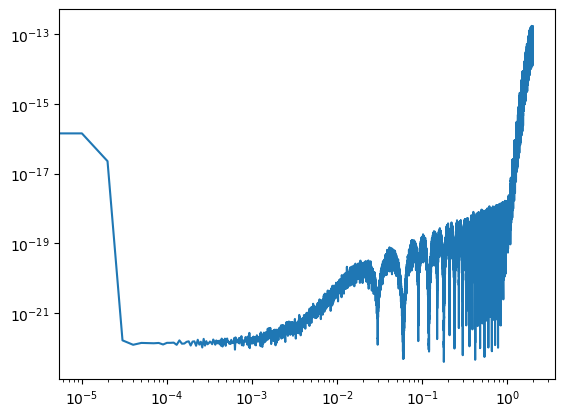

In [23]:
plt.loglog(f, np.sqrt(xpsd))

### 1.2 Data quicklook

Check the stencil size and take a look at the generated $y$s.

TDI2 fractional delay Lagrange interpolating polynomials are of order `31=1+15*2`

Overall TDI delays are up to 8x single link delay = `8.34 s * 4 Hz * 8` = about 267 sample. Add 15 on each end: `267 + 2*15 = 297` 

TDI2 overall stencil is then about 297 samples

aPCI overall stencil width is `1 + nhalf*2`

In [24]:
nhalf = 45
ns = int(pci_hours * 3600 * fs) 
window = np.ones(ns)

Plot 4000 data samples:

zsh:1: command not found: free


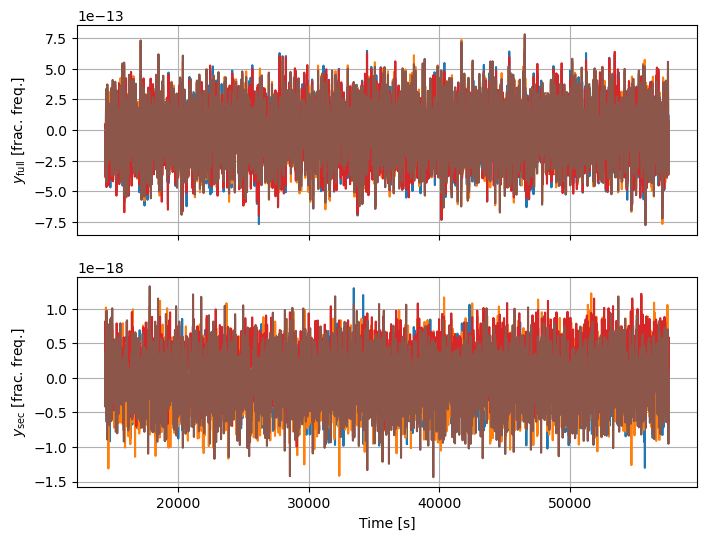

In [25]:
# Time series quicklook
maxshow=4000
ev=ns//maxshow+1
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex = True)
for ich in range(len(y_full.T)):
    axes[0].plot(times[skip:skip+ns:ev], y_full[skip:skip+ns:ev, ich])
for ich in range(len(y_sec.T)):
    axes[1].plot(times[skip:skip+ns:ev], y_sec[skip:skip+ns:ev, ich])
axes[1].set_xlabel('Time [s]')
axes[0].set_ylabel(r"$y_\text{full}$ [frac. freq.]")
axes[1].set_ylabel(r"$y_\text{sec}$ [frac. freq.]")
axes[0].grid(), axes[1].grid()
!free

## 2. Apply PCI to the data

We now resort to {class}`PCIFilter` to evaluate PCI from $\vec{y}$.

An instance of {class}`PCIFilter` has two required inputs:
- `ydata`: matrix with the single link LISA temporal phase data streams $\vec{y}$ of length `ns`.
- `fs`: sampling rate of the data streams (Hz).

The optional parameters are
- `nhalf`: filter stencil halfwidth in samples. The default is 45.
- `order`: order of PCI. The default is 1.
- `maxcompts`: PCA results will be truncated to this length after initial processing. The default is 10.
- `Tscale`: if dt is None, then dt defaults to Tscale/ns

The input channels $\vec{y}$ are stretches of data, usually of length `ns+2*nhalf`, but sometimes varying. The variations are:
  - `:` (full length of matrix)
  - `0:ns_fixed`
  - `0:ns+2*nhalf`
  - `skip:skip+ns+2*nhalf`
  
In every case the window is trivial `np.ones([data lenght])`

Creating an instance of the `PCIFilter` class applies the following methods, in order:

1. `pcipy.PCIFilter.build_data_matrix`
Pre-process $\vec{y}$ data `ydata` to build a matrix of shifted time-series. 

Output is a matrix $\vec{X}$ of size `[n_c * (2*nhalf+1)] x n_s` , 
$$
\vec{X} = \begin{bmatrix}
y_1(t_0) & y_1(t_1) &y_1(t_2) & \dots & y_1(t_{n_s}) \\
y_1(t_0-t_\text{st})& y_1(t_1-t_\text{st}) &y_1(t_2-t_\text{st}) & \dots & y_1(t_{n_s}-t_\text{st}) \\
y_1(t_0-2t_\text{st}) & \dots & \dots & \dots & y_1(t_{n_s}-2t_\text{st}) \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
y_1(t-n_\text{half}t_\text{st})&y_1(t_1-n_\text{half}t_\text{st}) &y_1(t_2-n_\text{half}t_\text{st}) & \dots & y_1(t_{n_s}-n_\text{half}t_\text{st}) \\
y_1(t_0-2t_\text{st}) & \dots & \dots & \dots &\dots \\
y_1(t_0+t_\text{st})& \dots & \dots & \dots &\dots \\
y_1(t_0+2t_\text{st}) & \dots & \dots & \dots &\dots \\
\vdots & \vdots & \vdots &\vdots &\vdots\\
y_1(t_0+t_\text{nhalf})& \dots & \dots & \dots &\dots \\
y_2(t_0) & \dots & \dots & \dots & \dots \\
y_2(t_0-t_\text{st}) & \dots & \dots & \dots &\dots \\
\vdots & \vdots & \vdots &\vdots &\vdots\\
y_2(t-n_\text{half}t_\text{st})& \dots & \dots & \dots &\dots \\
y_2(t_0+t_\text{st})& \dots & \dots & \dots &\dots \\
\vdots & \vdots & \vdots &\vdots &\vdots\\
y_2(t_0+n_\text{half}t_\text{st})& \dots & \dots & \dots &\dots \\
y_3(t_0) & \dots & \dots & \dots &\dots \\
\vdots & \vdots & \vdots &\vdots &\vdots\\
y_{n_c}(t_0+n_\text{half}t_\text{st}) & \dots  & \dots & \dots &  y_{n_c}(t_{n_s}+n_\text{half}t_\text{st})
\end{bmatrix}
$$
where $n_c=6$ is the size of the $y$s array, `nhalf=45` is the length of the time-shifting stencil and $n_s$ is the number of data samples in each $y$.

Option to detrend the data or make them zero-mean.

2. `pcipy.PCIFilter.apply_pca`
Apply Principal Component Analysis (PCA) to matrix $\vec{X}$. PCA is applied using the `PCA` class defined within [scikit learn](https://scikit-learn.org/stable/modules/decomposition.html#pca) `sklearn`, which 

> is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a transformer object that learns
components in its fit method, and can be used on new data to project it on these components.

From `PCA` object, evaluate components and explained variance. Option to sort components by RMS value.

4. `pcipy.PCIFilter.set_stencil`

### 2.1 Evaluate PCI on full data
#### 2.1.1 Sort components by variance

In [30]:
# import importlib
# importlib.reload(pci_filter)

Tscale=10
pca_list = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                 fs=fs, 
                                 nhalf=nhalf, 
                                 order=q, 
                                 maxcompts=10, 
                                 Tscale=Tscale,
                                 sort_by_rms=False,
                                verbose=True)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


(172800, 546)
variance check rms: 4.788607390183109e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 6.674430153617341e-10
component diagonality test on 10 components: 6.568202558137232e-16
datamatrix mean -2.505531351002216e-14
channels shape (10, 172800)
channel means [ 3.17752274e-22  4.87029239e-23  1.98968148e-21 -6.15879077e-21
 -1.20286124e-23  9.23410126e-21  3.81479872e-21  1.26464266e-22
 -9.20051685e-22  2.86855214e-21]
channel variances: [9.37076767e-42 1.87248256e-41 1.90856466e-41 3.46336554e-41
 3.73921694e-41 5.00233936e-41 5.84366743e-41 7.17228953e-41
 8.75628216e-41 1.08177625e-40 1.15496513e-40]
(172800, 1092)
variance check rms: 1.5507396745888192e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.00000001]
channel covariance diagonality test on 1

In [27]:
p = pca_list[0]
print(p.nsdata, p.nc, p.nhalf, p.nhalf*2+1, p.ns+2*p.nhalf, p.ns, p.maxcompts)

print((p.nhalf*2+1)* p.nc)

p.components.shape, p.explained_variance.shape, p.channels.shape



172890 6 45 91 172890 172800 10
546


((10, 546), (546,), (10, 172800))

#### 2.1.2 Sort components by RMS

In [28]:
pca_list_rs = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                    fs=fs, 
                                    nhalf=nhalf, 
                                    order=q, 
                                    maxcompts=10, 
                                    Tscale=Tscale,
                                    sort_by_rms=True)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


(172800, 546)
variance check rms: 4.788607390183109e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 6.674430153617341e-10
component diagonality test on 10 components: 6.568202558137232e-16
(172800, 1092)
variance check rms: 1.5507396745888192e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.00000001]
channel covariance diagonality test on 10 components: 2.714992901079027e-09
component diagonality test on 10 components: 1.407988493015824e-15
(172800, 1638)
variance check rms: 5.791933077997887e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[1.         0.99999999 1.         1.         0.99999998 1.
 0.99999999 0.99999999 1.         0.99999999]
channel covariance diagonality test on 10 components: 1.1625802384221913e-08
component diagonality te

#### 2.1.3 Detrend the components to get zero mean data

In [29]:
pca_list_zm = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                    fs=fs, 
                                    nhalf=nhalf, 
                                    order=q, 
                                    maxcompts=10, 
                                    Tscale=Tscale,
                                    zero_mean=True)            
            for q in range(3)]

ys (6, 172890)
means [-5.00808137e-14 -2.50902024e-14  1.33581115e-19 -5.02255642e-14
 -3.77759508e-20 -2.49453006e-14]
new means [ 7.15562408e-30  4.22375721e-30  5.70348853e-36  1.24656905e-29
 -2.60221664e-36  3.63679980e-30]
(172800, 546)
variance check rms: 4.578436097337933e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 4.5216790192051993e-10
component diagonality test on 10 components: 6.718769447780681e-16
ys (6, 172890)
means [-5.00808137e-14 -2.50902024e-14  1.33581115e-19 -5.02255642e-14
 -3.77759508e-20 -2.49453006e-14]
new means [ 7.15562408e-30  4.22375721e-30  5.70348853e-36  1.24656905e-29
 -2.60221664e-36  3.63679980e-30]
(172800, 1092)
variance check rms: 1.7663917481439927e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.         1.         1.         1.         0.99999999 0.99999999
 1.         1.         1.         1.        ]
channe

### 2.2 Plot PCI decomposition

Compare data sorted by variance with data sorted by RMS.

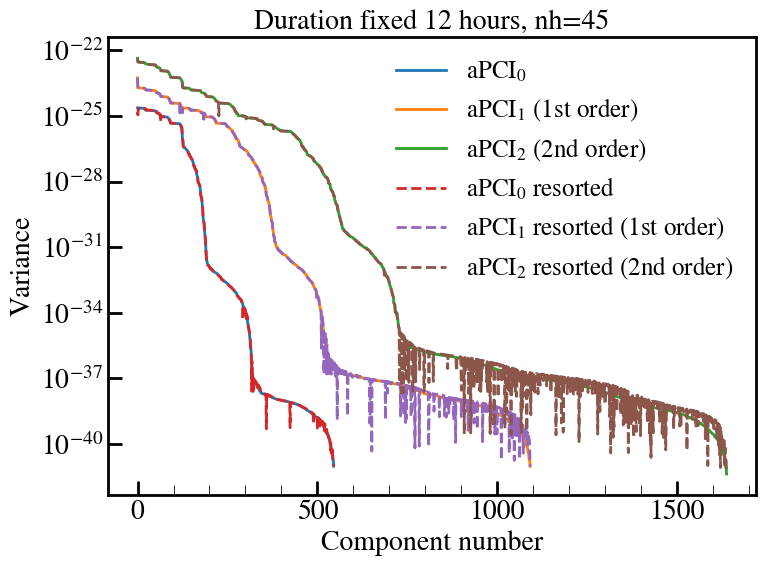

zsh:1: command not found: free


In [31]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

ax1.plot(pca_list[0].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_0$',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[1].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_1$ (1st order)',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[2].explained_variance,
            #linestyle='dashed',
            label=r'aPCI$_2$ (2nd order)',
            linewidth=2,
            rasterized=False)

if True:
    ax1.plot(pca_list_rs[0].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_0$ resorted',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[1].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_1$ resorted (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[2].explained_variance,
                linestyle='dashed',
                label=r'aPCI$_2$ resorted (2nd order)',
                linewidth=2,
                rasterized=False)

if False:
    ax1.plot(pca_list_zm[0].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_0$ zm',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[1].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_1$ zm (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[2].explained_variance,
                linestyle='dotted',
                label=r'aPCI$_2$ zm (2nd order)',
                linewidth=2,
                rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Component number", fontsize=20)
ax1.set_ylabel("Variance", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='upper right', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free
#for i in range(3):
#    print(pca_list[i].explained_variance-pca_list_zm[i].explained_variance)

## 3. Run channel analysis on the PCI output

The channel analysis we run here does the following:
- Compare stationarity of the data, for each applied PCI order

i= 0
mean: 3.177522739926926e-22
variance:  9.37076768417288e-42
mean: 4.8702923921851754e-23
variance:  1.8724825547613132e-41
mean: 1.9896814837290144e-21
variance:  1.9085646644889483e-41
mean: -1.2028612393137853e-23
variance:  3.7392169403243753e-41
mean: 1.2646426627255383e-22
variance:  7.17228953296344e-41
mean: -6.1587907726759196e-21
variance:  3.4633655341603567e-41
i= 1
mean: -1.7059007257703465e-21
variance:  9.264956348829331e-42
mean: 5.607480892120897e-21
variance:  7.009640494902143e-41
mean: -3.851202528666826e-21
variance:  1.4962061381406142e-40
mean: 4.181367329871874e-21
variance:  1.5390676074180504e-40
mean: -3.0291388733988414e-21
variance:  2.248251849277606e-40
mean: 1.0362466396495903e-20
variance:  1.5823947590419738e-40
i= 2
mean: 7.713883204198668e-22
variance:  4.154180373347937e-42
mean: -1.5173850312553988e-22
variance:  1.7069257038647179e-41
mean: -4.737420819796916e-21
variance:  1.826045592754432e-41
mean: -4.293889082945975e-21
variance:  3.118469

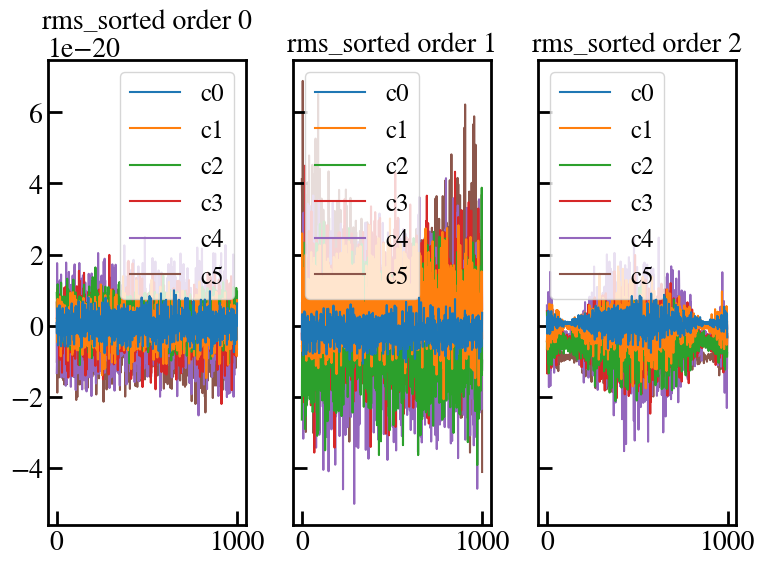

In [32]:
order=2
ev=100

# select which order of PCI filter you want to look at
filters=[pca_list_rs[o] for o in range(order+1)]
# select titles for plot
titles = ['rms_sorted order '+str(o) for o in range(order+1)]
# CONTROLLA COSA FA APPLY FOR CHANNELS
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, 
                                     n_channels=6,
                                     zero_mean=False,
                                     detrend=False)) 
      for xf in filters]
# run channel analysis on selected channels and filter orders
channel_analysis.stationarity_plots(sets,
                                    title=titles)

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 2
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


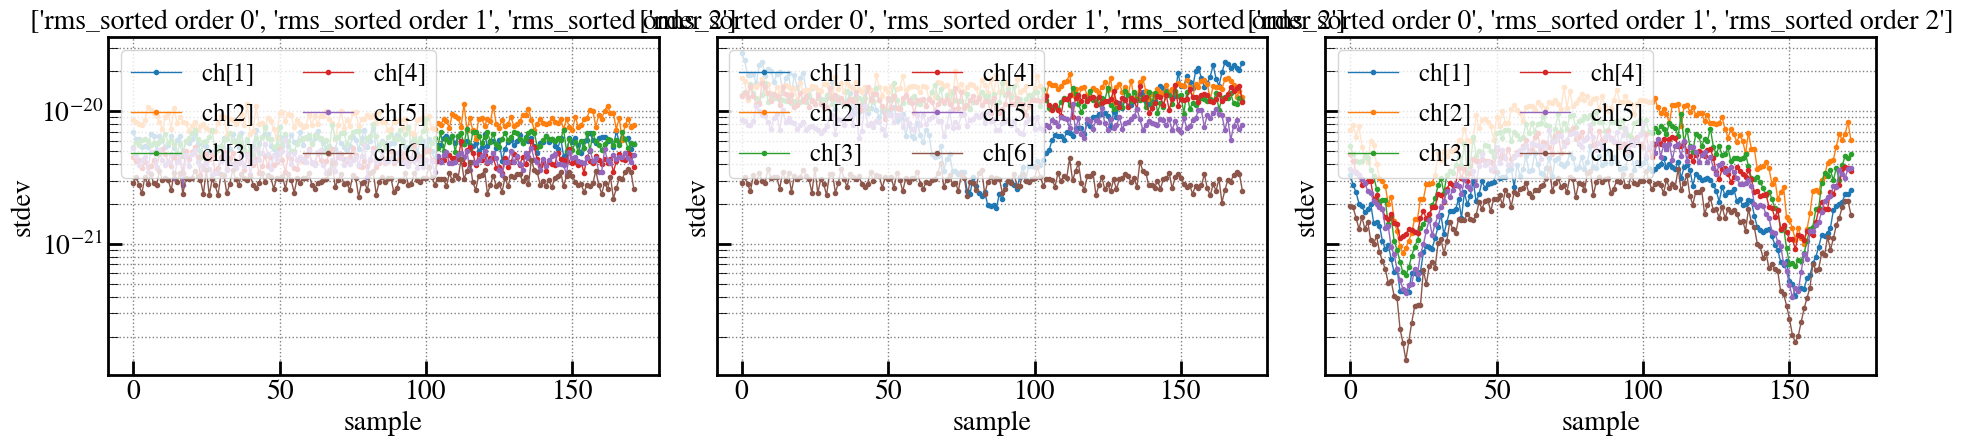

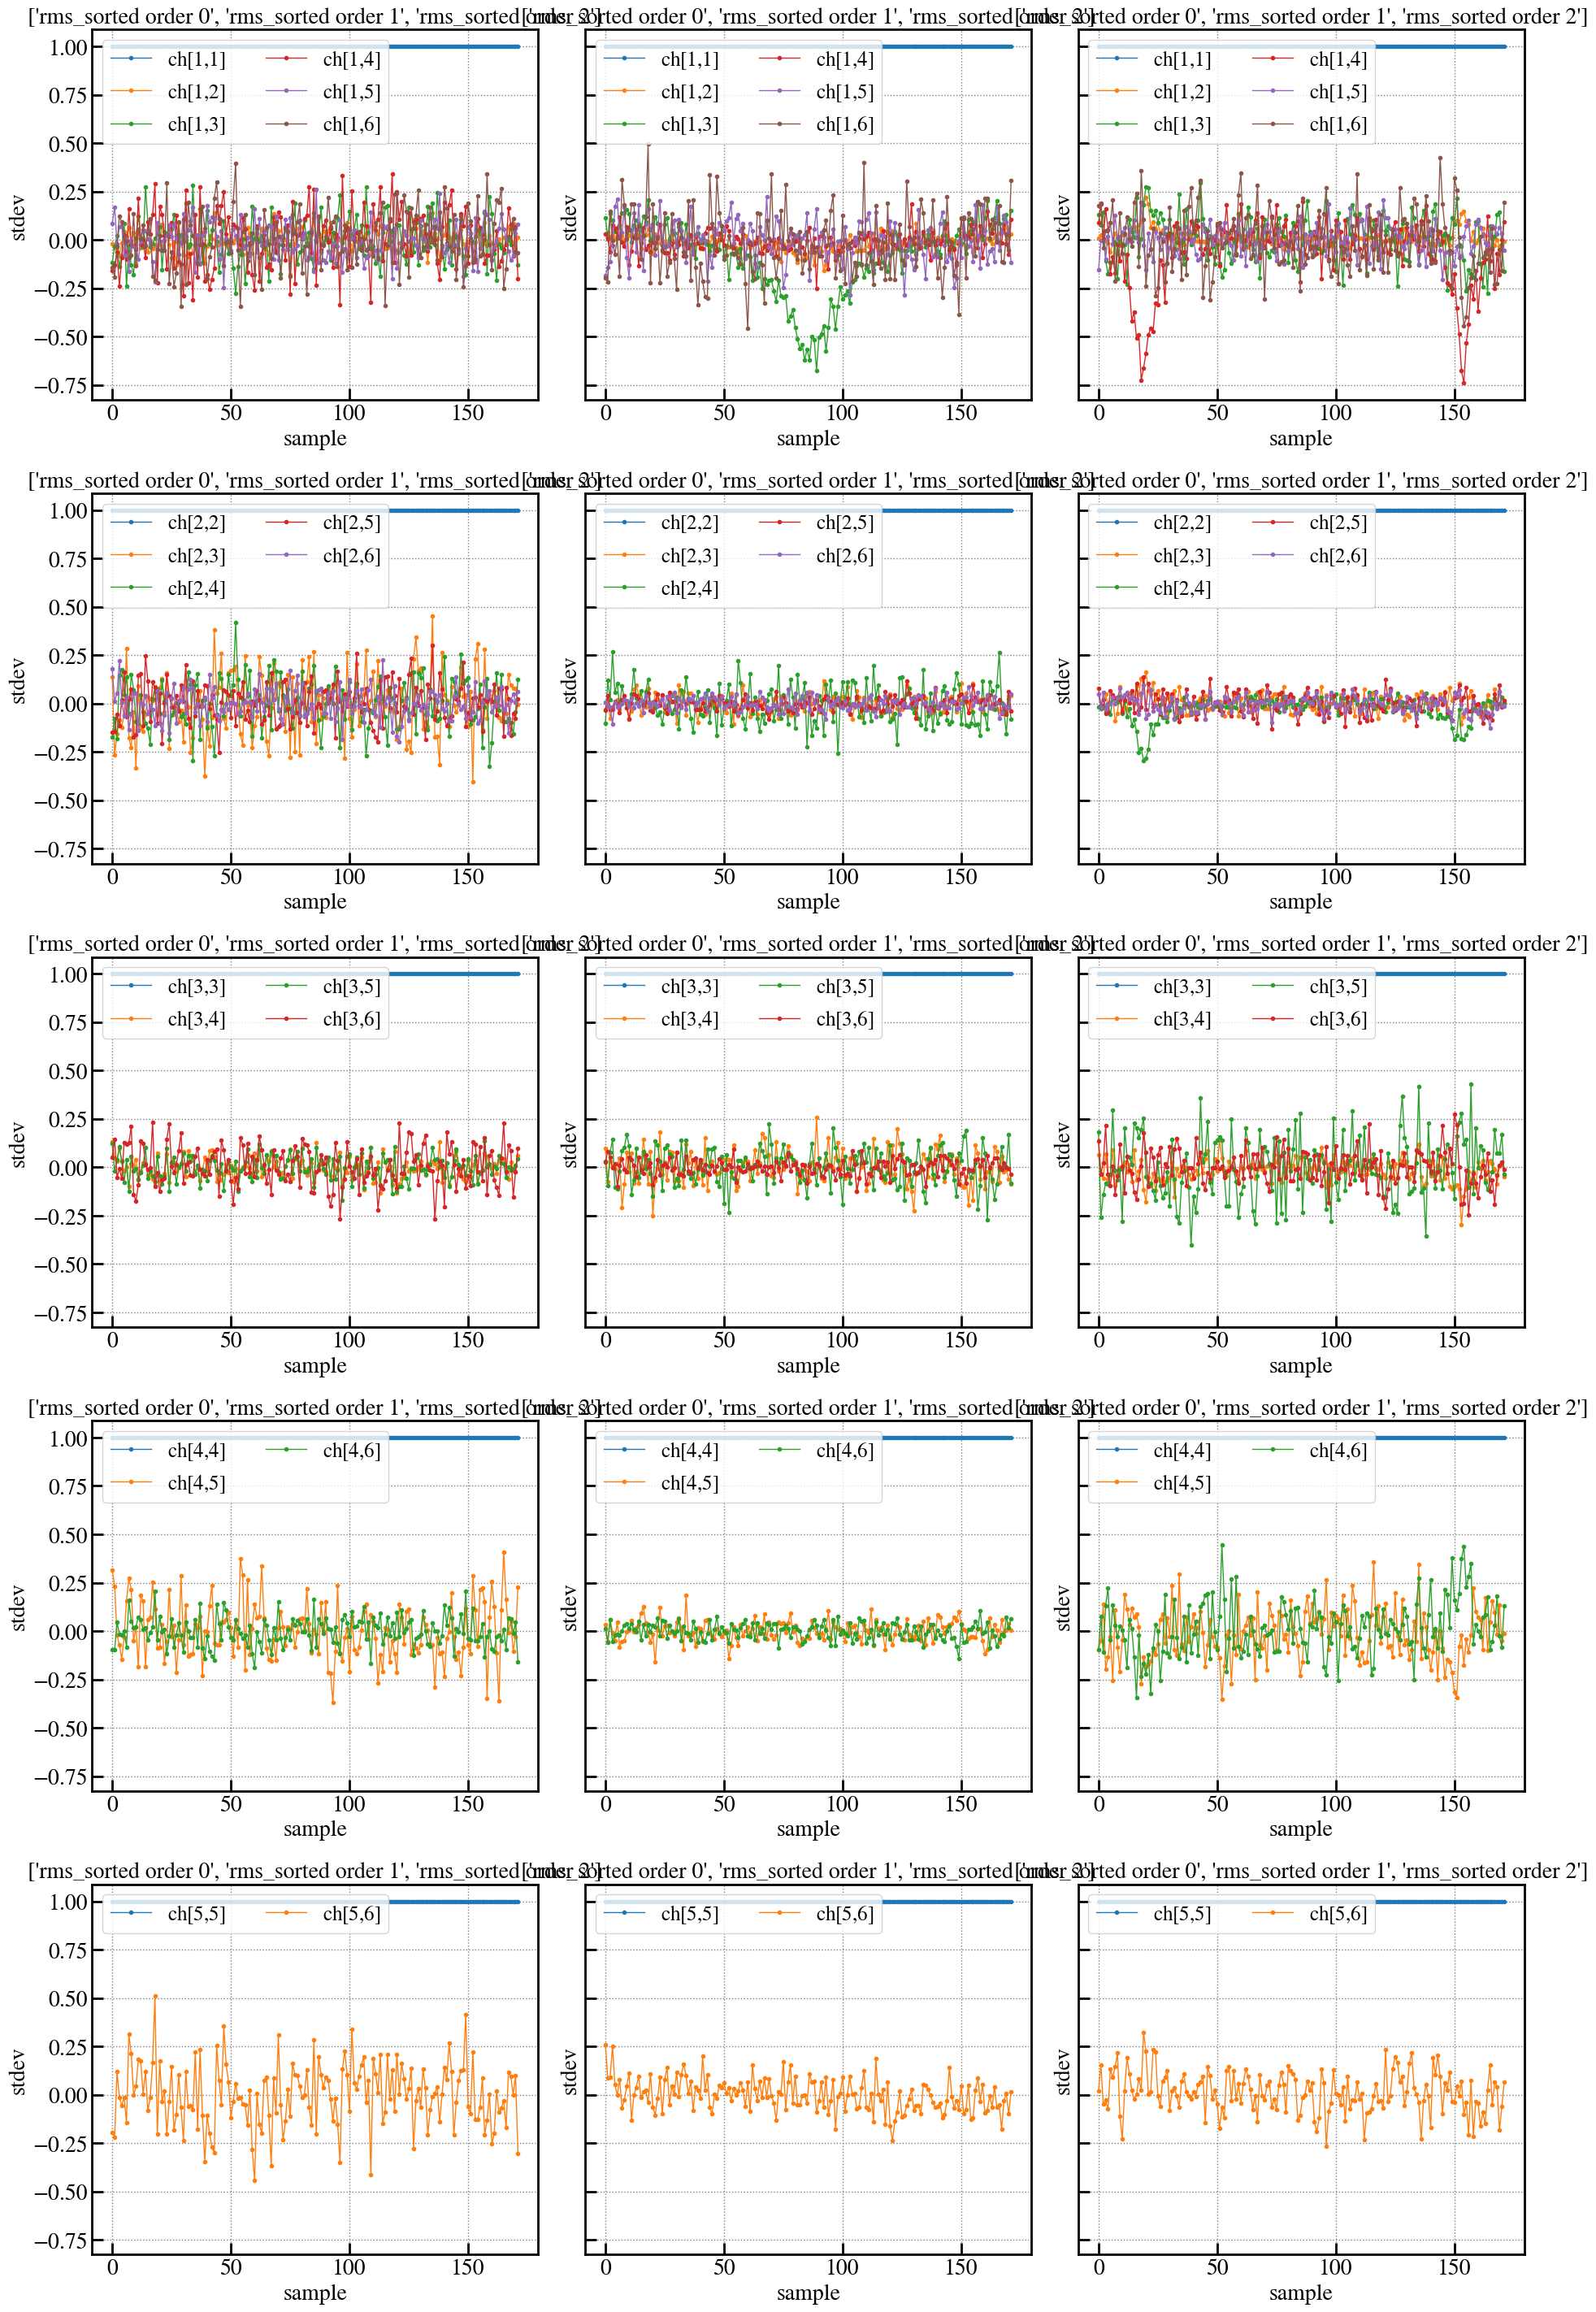

In [33]:
order=2
ev=100

# select which order of PCI filter you want to look at
filters=[pca_list_rs[o] for o in range(order+1)]
# select titles for plot
titles = ['rms_sorted order '+str(o) for o in range(order+1)]

# select data channels (?)
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T,
                                     n_channels=6,
                                     zero_mean=False,detrend=False)) 
      for xf in filters]
# FIX TITLES IN THIS PLOT FUNCTION
channel_analysis.temporal_variance_corr_plots(sets,
                                              nchan=6,
                                              title=titles)

### 3.1 Frequency Domain analysis

In [34]:
def compute_welch_matrix(ydata, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat


Apply Welch to matrix of time-shifted $y$s:

In [35]:
# Welch settings
nperseg = 2**16 # didn't work with some, too short data segment (6hr)?
nperseg = 2**14

kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

# apply Welch
freqs, y_welch_mat = compute_welch_matrix(y_full, **kwargs)
freqs, y_sec_welch_mat = compute_welch_matrix(y_sec, **kwargs)

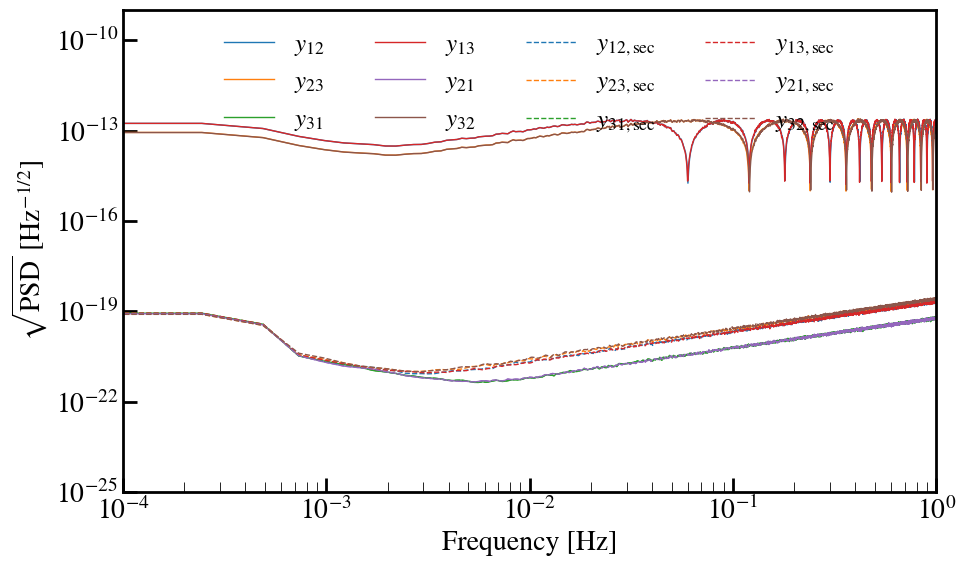

In [36]:
# define ordering of the MOSAs in the constellation
mosas_order = ['12', '23', '31', '13', '21', '32']

# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

# plot
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_welch_mat[:, i, i].real), 
                linewidth=1, 
                label=r'$y_{\mathrm{'+mosas_order[i]+'}}$',
                rasterized=True)
plt.gca().set_prop_cycle(None)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1,ls='--', 
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='upper center', ncol=4, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
axes.set_ylim([1e-25, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

## 4. Reconstruct single-link channels

Computing single link
single link shape (6, 172800)
single link shape (6, 172800)
Computed single link
i= 0
mean: -8.182024826193479e-23
variance:  3.6971071384062734e-45
mean: -5.110115899996264e-22
variance:  7.523099155263497e-43
mean: -1.2783707788441508e-22
variance:  2.8548953585047436e-44
mean: -3.8058256655018512e-22
variance:  9.58223524698778e-43
mean: 8.046227032866446e-23
variance:  3.4231738544586696e-45
mean: 1.2783707971428205e-22
variance:  2.8548954323865177e-44
i= 1
mean: 2.1167889149269115e-23
variance:  7.08001045766806e-46
mean: 1.7254584875177572e-22
variance:  3.9019409471068776e-43
mean: 3.3075162217053066e-23
variance:  1.92062828376719e-45
mean: 1.5158765263718594e-22
variance:  5.099864555832087e-43
mean: -2.1184025986206925e-23
variance:  7.25834364445459e-46
mean: -3.30751617828784e-23
variance:  1.9206284916274338e-45
i= 2
mean: -5.951647893869697e-20
variance:  1.4610713640513951e-37
mean: -3.7780369972256833e-20
variance:  7.292833188888567e-39
mean: 1.3

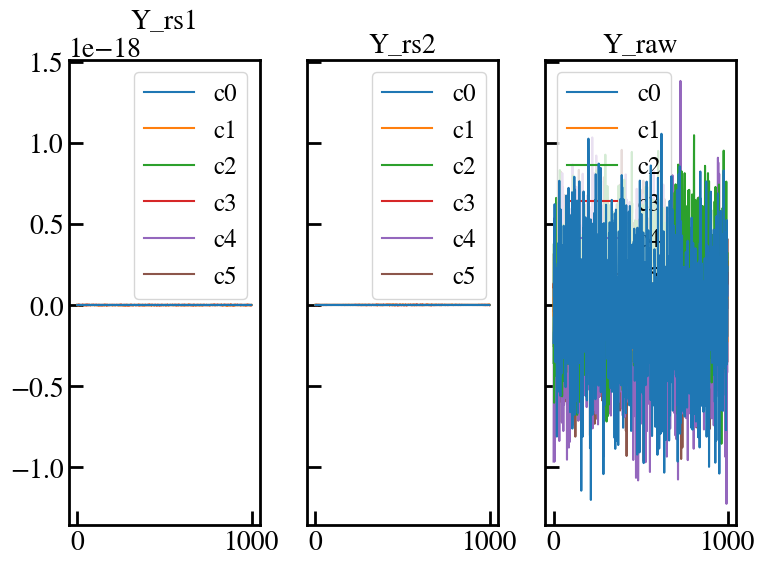

In [37]:
order=2
nchannels=10
ev=100

filters=[pca_list_rs[order-1],pca_list_rs[order]]

[xf.set_stencil(nchannels) for xf in filters]

sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, 
                                     n_channels=nchannels,
                                     zero_mean=False,detrend=False)) 
      for xf in filters]

print("Computing single link")

Ysets=[xf.compute_single_links_from_channels(iset) 
       for xf,iset in zip(filters,sets)]

titles=['Y_rs'+str(order-1),'Y_rs'+str(order)]

if True:
    Ysets+=[y_sec[nhalf:ns+nhalf, :].T]
    titles+=['Y_raw']
    
print("Computed single link")
channel_analysis.stationarity_plots(Ysets,
                                    title=titles)

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 2
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


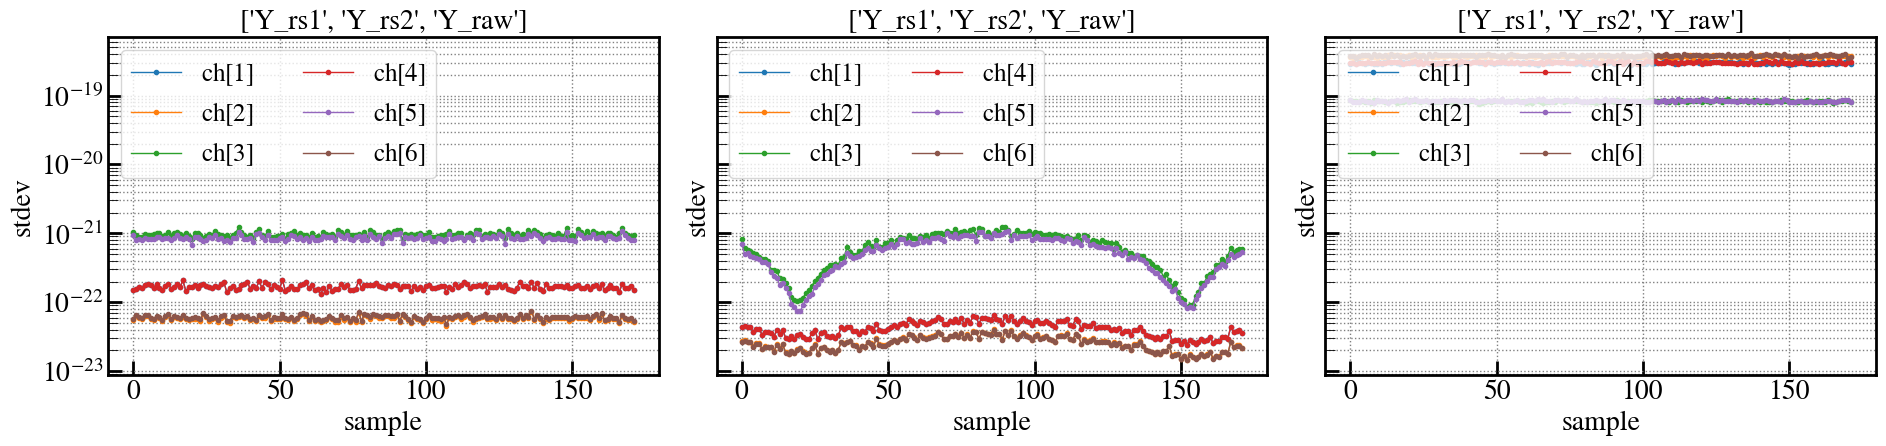

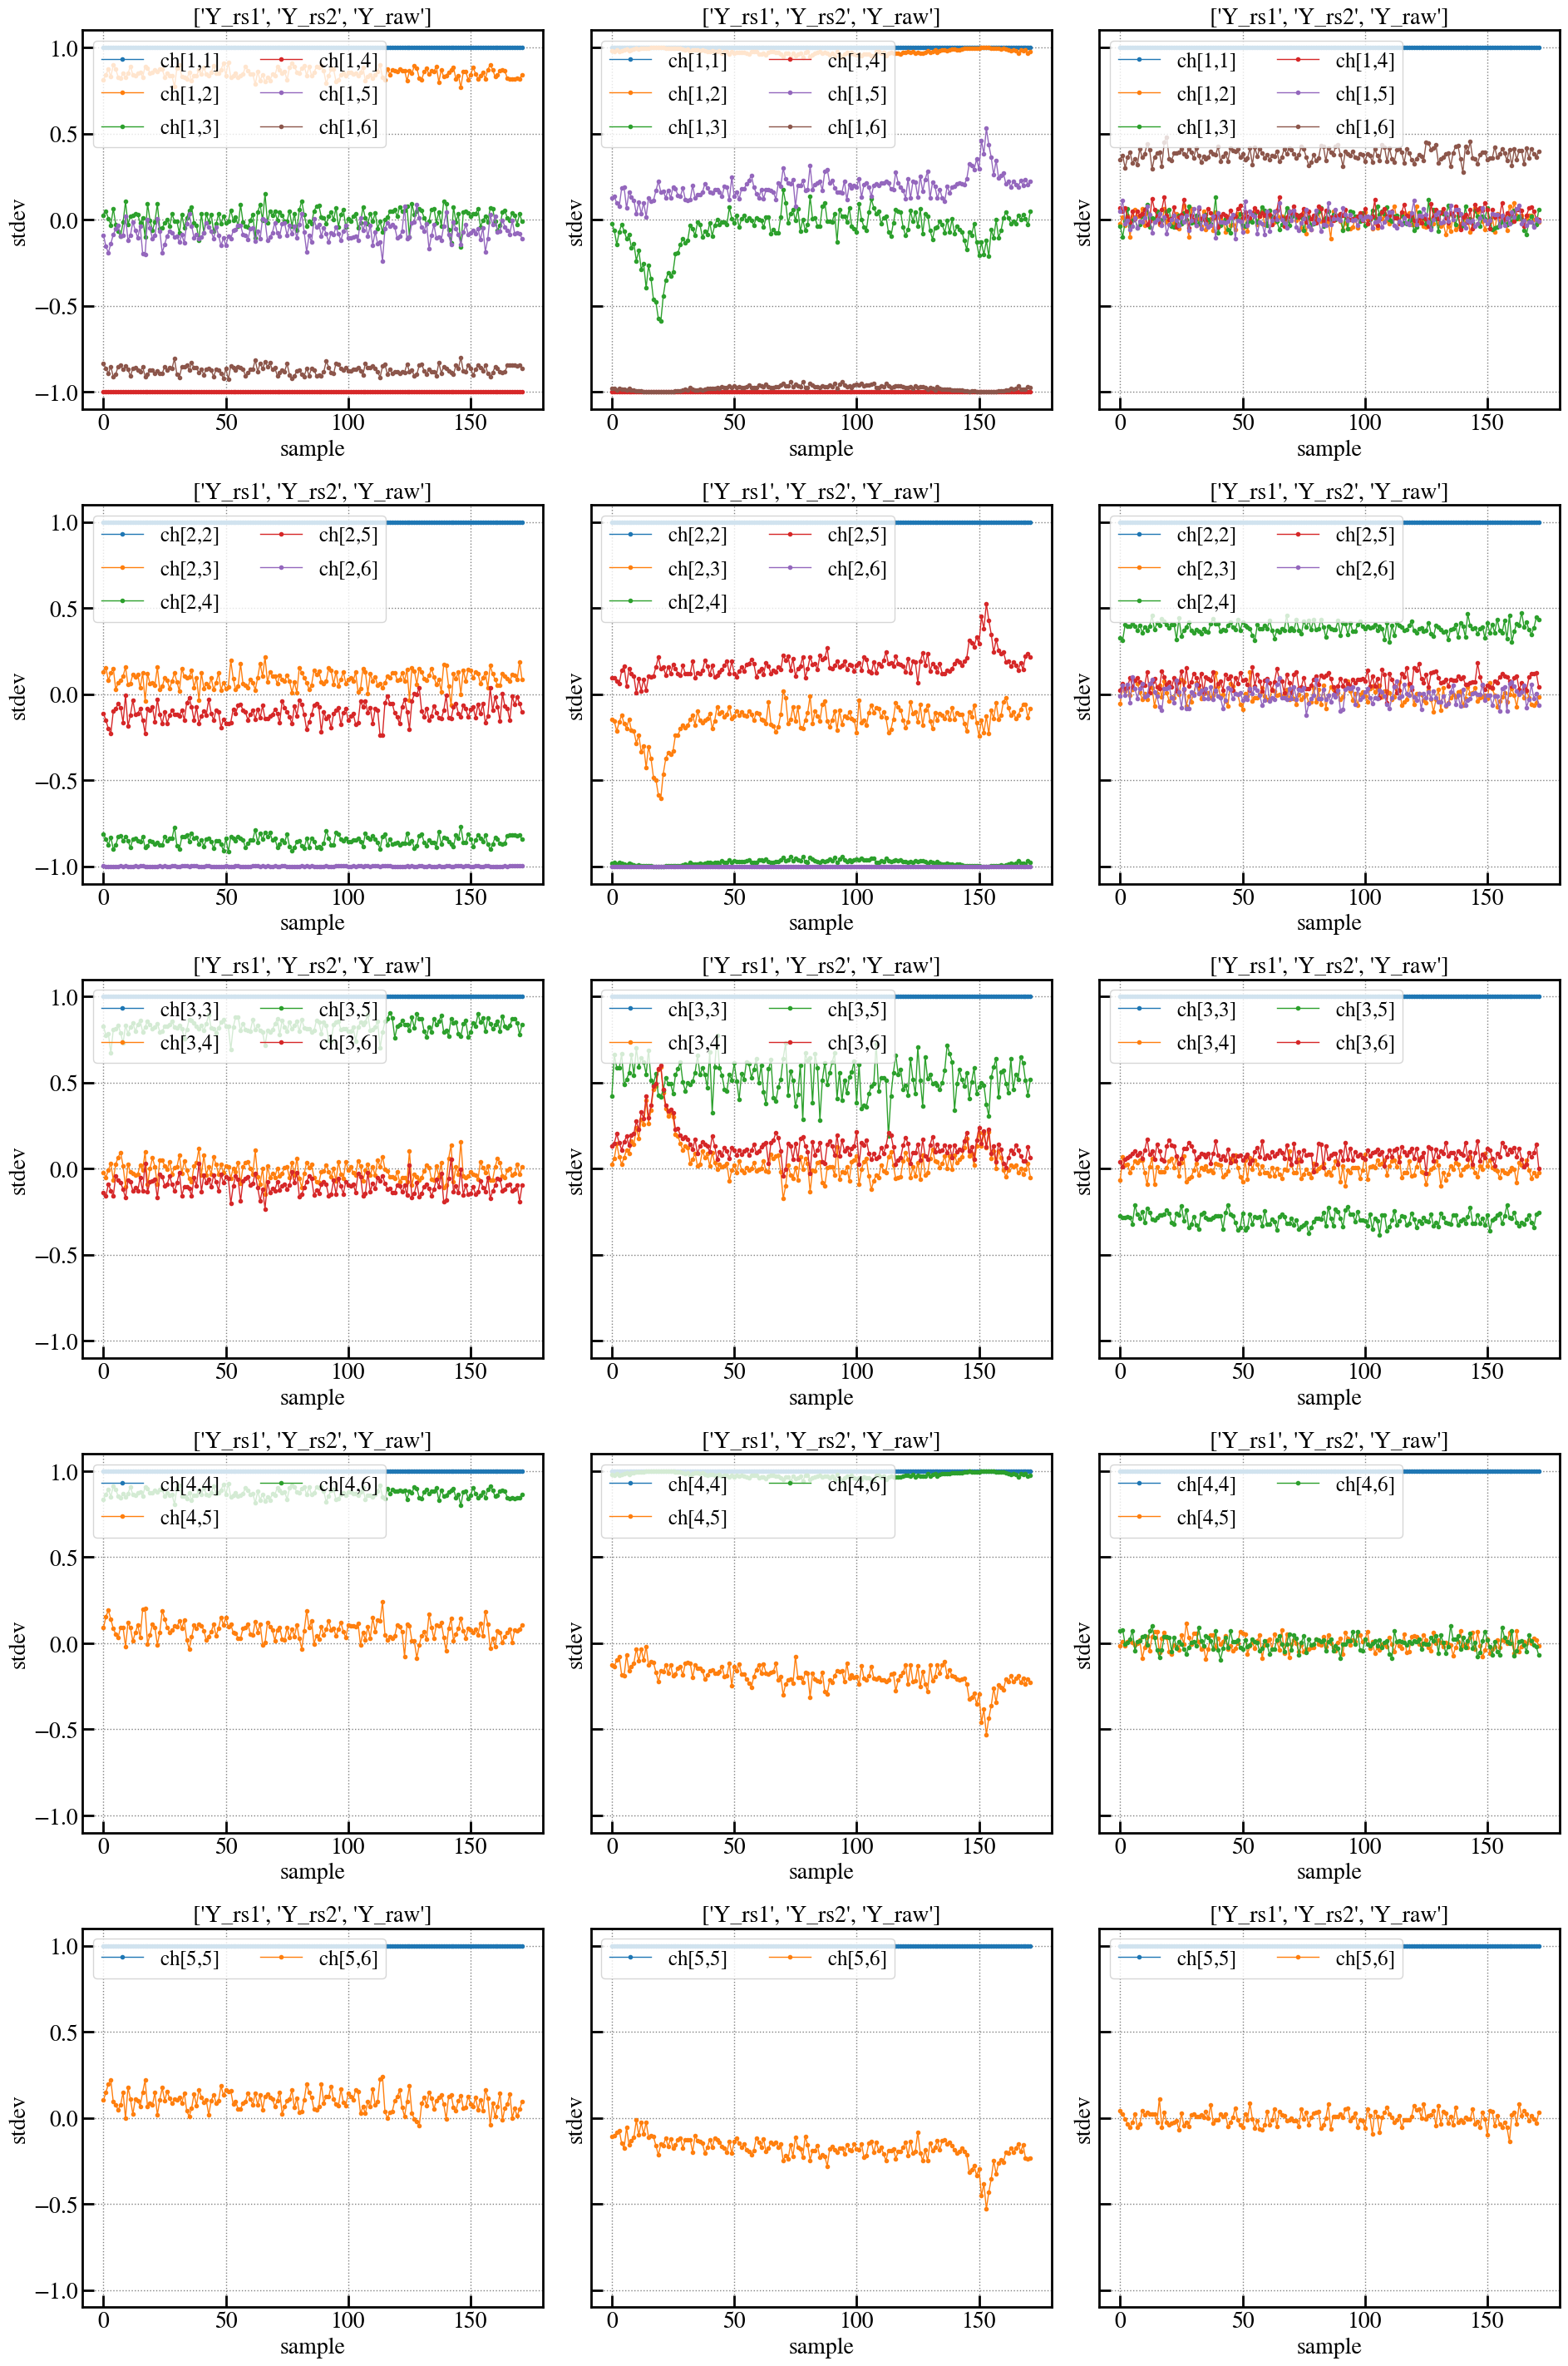

In [38]:
channel_analysis.temporal_variance_corr_plots(Ysets[:],
                                              nchan=6,
                                              title=titles)

In [39]:
freqs1, y_pci1_welch_mat = compute_welch_matrix(Ysets[0].T, **kwargs)
freqs2, y_pci2_welch_mat = compute_welch_matrix(Ysets[1].T, **kwargs)

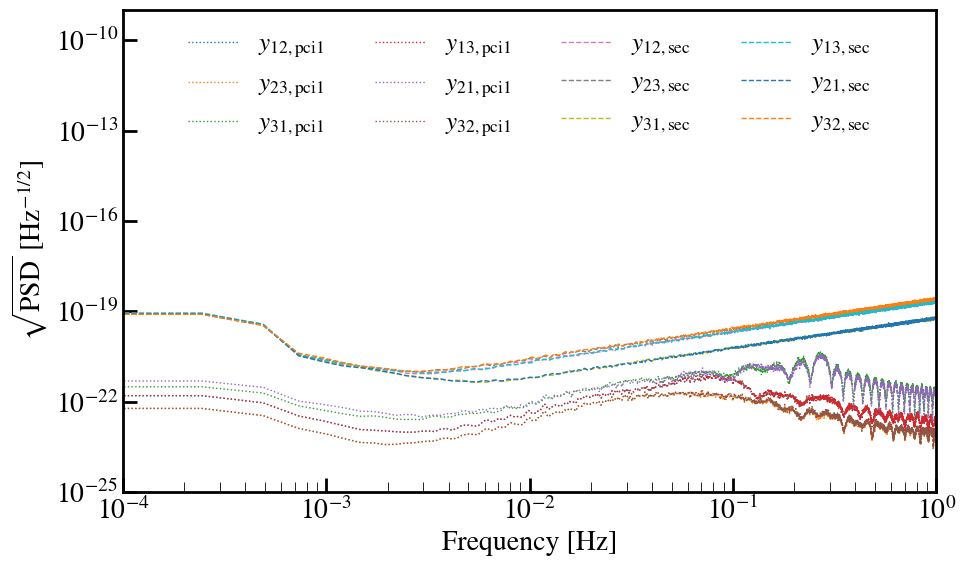

In [40]:
# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_pci1_welch_mat[:, i, i].real), 
                linewidth=1, ls=':',
                label=r'$y_{\mathrm{'+mosas_order[i]+',pci1}}$',
               rasterized=True)
#for i in range(6):
#    axes.loglog(freqs, np.sqrt(y_pci2_welch_mat[:, i, i].real), 
#                linewidth=1, 
#                label=r'$y_{\mathrm{'+mosas_order[i]+',pci2}}$',
#               rasterized=True)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1, ls='--',
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='upper center', ncol=4, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
axes.set_ylim([1e-25, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

Alternative $Y$ reconstruction

In [41]:
    def filter_single_link_data(self, ydata,n_channels=None):
        '''
        Compute recovered single-link channel vectors from a set of single-link data. This should yield 
        identical results to appropriately called compute_single_link_from_channels but we first implement
        separately for testing, since the stencil_compts stuff is new. This one is more low-level and 
        doesn't assum the stencil is selected.
        
        Parameters
        ----------
        ydata : ndarray 
            The raw single-link data-set to be transformed.

        Returns
        -------
        reconstructed_ydata : ndarray
            Reconstructed single link data channels
        '''
        if n_channels is None: n_channels=self.maxcompts
        y_transformer=self.components[-n_channels:,:6].T

        chans_data = self.apply_for_channels(ydata, n_channels)
        Z=np.dot(y_transformer,chans_data)
        print('single link data shape', Z.shape)
        return Z

In [42]:
Zsets=[np.array(xf.filter_single_link_data(y_full[:ns+2*nhalf, :].T, n_channels=nchannels)) for xf in filters]
print("Comparing single link")
diff=[Zsets[i]-Ysets[i] for i in range(order)]
print(diff)

single link data shape (6, 172800)
single link data shape (6, 172800)
Comparing single link
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]


## 5. Estimate sensitivity
### Computation of empirical response with welch periodograms
Based and empirical sensitivity calculation simulated signal over simulated noise as developed in initial-dev-from-pylisa

In [43]:
# Some options and prep for the welch_matrix calc
nperseg = 1e4
welch_kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

#and for the orthogonalization...
#multiple_dot = lambda a,b: np.einsum("ijk, ikl -> ijl", a, b)
def multiple_dot(a_mat, b_mat):
    """
    Perform the matrix multiplication of two list of matrices.

    Parameters
    ----------
    a : ndarray
        series of m x n matrices (array of size p x m x n)
    b : ndarray
        series of n x k matrices (array of size p x n x k)

    Returns
    -------
    c : ndarray
        array of size p x m x k containg the dot products of all matrices
        contained in a and b.


    """

    return np.einsum("ijk, ikl -> ijl", a_mat, b_mat)


In [44]:

def estimate_sensitivity(pci, data_n, data_gw, n_channels=6, joint=True, single_link=False, welch_kwargs=welch_kwargs):
    
    # PCI transformation vector, size n_channel x p
    #v_pci = pci.v_pci(n_channels)
    # Projection of the data segment t
    #print('compute noise channels')
    #print('for',n_channels,'channels')
    #print('components shape',pci.components.shape)
    if single_link:
        e_pci_n = pci.filter_single_link_data(data_n,n_channels).T
        e_pci_gw = pci.filter_single_link_data(data_gw,n_channels).T
    else:
        e_pci_n = pci.apply_for_channels(data_n,n_channels).T
        e_pci_gw = pci.apply_for_channels(data_gw,n_channels).T
    #print(e_pci_n.shape,e_pci_n.shape)
    #print('compute welch')
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_n_mat = compute_welch_matrix(e_pci_n, **welch_kwargs)
    print(freqs, e_pci_n_mat)
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_gw_mat = compute_welch_matrix(e_pci_gw, **welch_kwargs)
    print(freqs, e_pci_gw_mat)
    # Orthogonalization
    _, s, vh = np.linalg.svd(e_pci_n_mat)
    # Apply the orthogonal transformation to the GW signal    
    e_pci_gw_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_gw_mat, np.swapaxes(vh, 1, 2).conj()))
    # Apply the orthogonal transformation to the noise covariance
    e_pci_n_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_n_mat, np.swapaxes(vh, 1, 2).conj()))
    # Output sensitivity for each variable, size nfreqs x n_channels
    # pci_sens = np.array([np.abs(s[:, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    pci_sens = np.array([np.abs(e_pci_n_mat_ortho[:, j, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    
    print("Computation completed.")
    if joint:
        pci_sens = 1 / np.sum(1/np.array(pci_sens), axis=1)
    
    return freqs, pci_sens

def process_data(y_noise, y_gw, fs, nhalf, order=1, n_channels=6, pca_y_noise=None, joint=False, pci_kwargs={}, welch_kwargs={}):
    '''
    Apply PCI and compute sensitivity all wrapped up together. If pda_y_noise is provided it is used
    only for computing the PCI and y_noise is used only for the sensitivity application
    '''
    
    if pca_y_noise is None: pca_y_noise=y_noise
        
    print('nhalf:',nhalf, 'sens data_size:',len(y_noise),'pca data_size:',len(pca_y_noise))
    
    # Get the length of the time series
    data_size = y_noise.shape[0]
    # data_noise = Data.from_instrument(instr_data)

    print('compute PCI')
    pci=pci_filter.PCIFilter(y_noise, fs, maxcompts=10, nhalf=nhalf,order=order,**pci_kwargs)
    
    result=estimate_sensitivity(pci, y_noise, y_gw, n_channels=n_channels, joint=joint, welch_kwargs=welch_kwargs)
    del(pci)
    
    return result

#### We need to read matching GW simulations results for the empirical sensitivity calculation

In [75]:
gw_path = workdir+dtpath["point_source"][:-2]+datasets["point_source"]+measpath

data_gw = Data.from_gws(gw_path,orbits)

#gw_dataset='tps/y'
#hdf5 = h5py.File(gw_path, 'r')
#dset=hdf5[gw_dataset]

#measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(mosas_order)}
#hdf5.close()

y_list = [data_gw.measurements[f'isi_{link}'] for link in mosas_order]
y_gw = np.array(y_list, dtype=np.float64).T[skip:, :]




## test

y_gw = build_data_vector(data_gw)



You are using a GW file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported


In [76]:
y_gw, y_full

(array([[-3.33277393e-15, -5.53663447e-16,  5.63958814e-15,
         -1.48501694e-15,  3.13817033e-16, -3.52102996e-16],
        [ 3.01807293e-15,  2.57712811e-16,  1.08727885e-15,
         -6.35111457e-15,  1.22707821e-16, -1.25289406e-16],
        [ 7.40737454e-15,  1.13948182e-15, -5.72810396e-15,
         -4.44569525e-15, -5.90346914e-16, -9.77783129e-15],
        ...,
        [ 3.44426741e-15,  3.34669903e-16, -1.77038595e-15,
         -3.41662108e-15,  5.05030951e-17, -9.16855492e-15],
        [-7.50516905e-16, -2.92810052e-15, -3.58635538e-16,
         -3.77004909e-15, -5.68659131e-17,  5.60808749e-15],
        [ 4.69389422e-16,  2.47403043e-15,  2.16027734e-15,
          2.23457287e-15, -9.01688557e-16,  7.91998972e-15]]),
 array([[-1.40613042e-13,  1.56159220e-14, -9.36263657e-20,
         -1.63047763e-13,  6.81765518e-21,  9.58397137e-15],
        [-1.19341142e-13,  1.01629926e-13,  1.63247609e-19,
         -1.43685718e-13, -2.88639685e-20,  1.29953359e-13],
        [ 2.87817

#### For comparison, we also need the TDI data

In [77]:
#tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
tdipath2 = workdir +  dtpath['noise'] + datasets['noise'] + '_noise_tdi2_4Hz.h5'
# open hdf5 TDI file
#tdi1 = h5py.File(tdipath1, 'r')
tdi2 = h5py.File(tdipath2, 'r')

x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq

tdi2_gw_file = workdir+dtpath["point_source"][:-2]+datasets["point_source"]+"_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x'][()]
y2_gw = hdf5['y'][()]
z2_gw = hdf5['z'][()]
hdf5.close()

# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)

# Orthogonalization
u_tdi, s_tdi, vh_tdi = np.linalg.svd(p_tdi2_n_mat)

# Apply the orthogonal transformation to the GW signal
p_tdi2_gw_mat_ortho = multiple_dot(vh_tdi, 

multiple_dot(p_tdi2_gw_mat, np.swapaxes(vh_tdi, 1, 2).conj()))

# Empirical orthogonalization of TDI
mean_tdi2 = 1 / np.sum(
    np.array([np.abs(p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi] / np.abs(s_tdi[:, j_tdi])) for j_tdi in range(3)]), axis=0)

#### PCI channel sensitivities

In [78]:
print(ns)
print(y_full[0:ns,:].T)
print(y_gw[0:ns,:].T)
display(welch_kwargs)

172800
[[-1.40613042e-13 -1.19341142e-13  2.87817563e-14 ...  5.11064672e-13
   1.43822973e-13 -2.11086293e-14]
 [ 1.56159220e-14  1.01629926e-13 -4.32284216e-14 ...  3.53423989e-13
   1.02923685e-13  1.64932983e-13]
 [-9.36263657e-20  1.63247609e-19  1.02532005e-20 ...  2.31030771e-19
   1.96167799e-19  1.92001877e-19]
 [-1.63047763e-13 -1.43685718e-13  5.08047292e-14 ...  4.84724341e-13
   1.97964994e-13 -5.42952100e-14]
 [ 6.81765518e-21 -2.88639685e-20 -3.98898274e-20 ... -1.05601285e-19
  -9.93652529e-20  1.00617335e-19]
 [ 9.58397137e-15  1.29953359e-13 -4.79889212e-14 ...  3.74002725e-13
   8.48001447e-14  1.58512856e-13]]
[[-3.33277393e-15  3.01807293e-15  7.40737454e-15 ... -2.36462325e-15
  -6.94509415e-15  5.30342136e-15]
 [-5.53663447e-16  2.57712811e-16  1.13948182e-15 ... -1.23046967e-15
  -1.14542619e-16 -9.02270579e-16]
 [ 5.63958814e-15  1.08727885e-15 -5.72810396e-15 ... -1.13517684e-15
  -4.51265387e-15 -2.44261361e-15]
 [-1.48501694e-15 -6.35111457e-15 -4.44569525e-

{'fs': np.float64(4.0),
 'window': 'blackman',
 'nperseg': 10000.0,
 'detrend': 'constant',
 'return_onesided': True,
 'scaling': 'density'}

In [79]:
#Test as it appears in the initial-dev notebook
nh=45
pci_sens_list = [
#    ["PCI-0 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-1 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-2 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-0 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
#    ["PCI-1 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
    ["PCI-2 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, fs, nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=welch_kwargs)] 
]

nhalf: 45 sens data_size: 6 pca data_size: 6
compute PCI
(172710, 1638)
variance check rms: 1.7169635020641684e-08
shapes of chans, cov, components: (10, 172710) (10, 10) (10, 1638)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 5.834612864967762e-11
component diagonality test on 10 components: 1.3406033488357905e-15
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 1.15450206e-44+0.00000000e+00j -8.82298137e-45+0.00000000e+00j
   -9.81514412e-46+0.00000000e+00j -1.87508327e-45+0.00000000e+00j
   -5.08181272e-45+0.00000000e+00j  1.45805719e-45+0.00000000e+00j]
  [-8.82298137e-45-0.00000000e+00j  1.73597948e-44+0.00000000e+00j
   -3.97040903e-45+0.00000000e+00j  1.09553447e-44+0.00000000e+00j
   -1.07024572e-44+0.00000000e+00j  2.78218032e-46+0.00000000e+00j]
  [-9.81514412e-46-0.00000000e+00j -3.97040903e-45-0.00000000e+00j
    4.15099652e-45+0.00000000e+00j -7.21037683e-45+0.00000000e+00j
    1.19457398e-44+0.00000000e+0

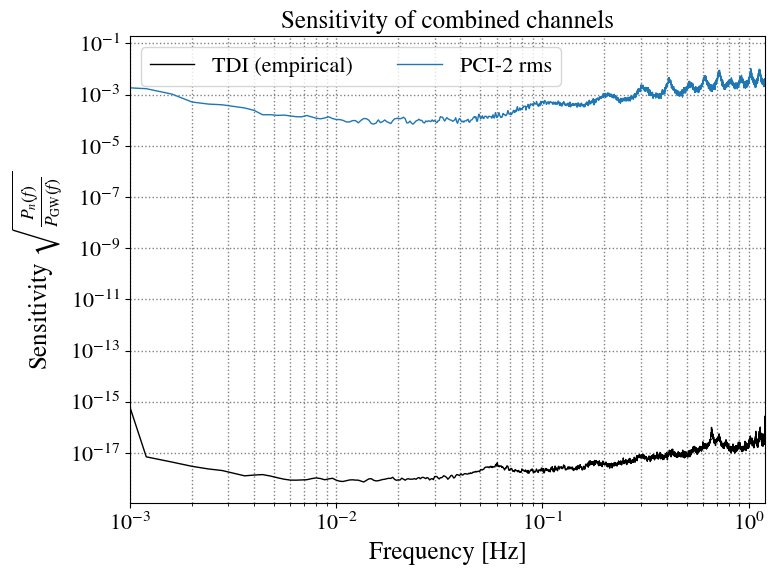

In [81]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

In [57]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" rms", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]




[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 8.89748812e-42+0.00000000e+00j -4.51742470e-43+0.00000000e+00j
    6.56842683e-43+0.00000000e+00j -6.68991394e-43+0.00000000e+00j
    4.11590286e-43+0.00000000e+00j -3.97864300e-43+0.00000000e+00j]
  [-4.51742470e-43-0.00000000e+00j  2.19682188e-43+0.00000000e+00j
   -3.70105525e-44+0.00000000e+00j  5.35463571e-44+0.00000000e+00j
    2.41178239e-44+0.00000000e+00j  1.88766544e-44+0.00000000e+00j]
  [ 6.56842683e-43-0.00000000e+00j -3.70105525e-44-0.00000000e+00j
    1.24745252e-43+0.00000000e+00j -4.35607379e-44+0.00000000e+00j
    2.47990871e-44+0.00000000e+00j  1.12095523e-44+0.00000000e+00j]
  [-6.68991394e-43-0.00000000e+00j  5.35463571e-44-0.00000000e+00j
   -4.35607379e-44-0.00000000e+00j  1.87038212e-43+0.00000000e+00j
   -4.40387336e-44+0.00000000e+00j  1.54831875e-44+0.00000000e+00j]
  [ 4.11590286e-43-0.00000000e+00j  2.41178239e-44-0.00000000e+00j
    2.47990871e-44-0.00000000e+00j -4.40387336e-44-0.

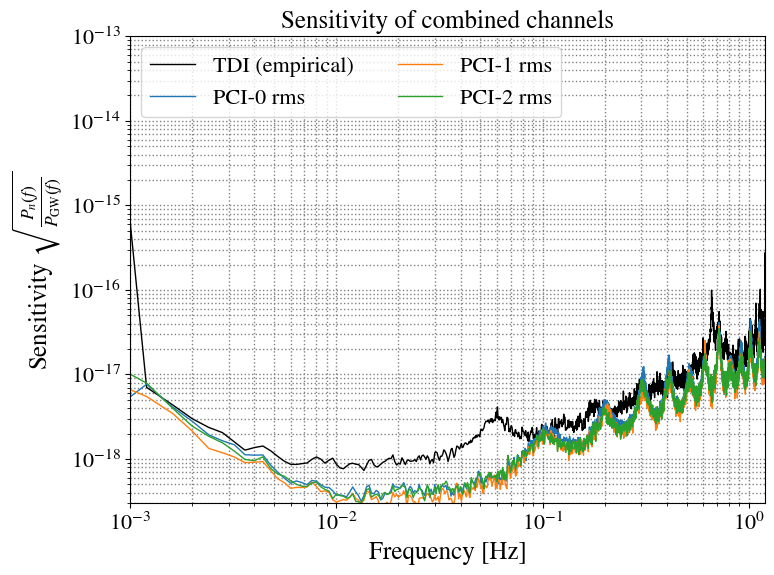

In [58]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

Reconstructed single link sensitivities

In [59]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]

single link data shape (6, 172710)
single link data shape (6, 172710)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 5.01448961e-49+0.00000000e+00j  4.11360096e-51+0.00000000e+00j
   -9.12264562e-48+0.00000000e+00j -5.01448730e-49+0.00000000e+00j
    2.39898629e-47+0.00000000e+00j  9.02295192e-51+0.00000000e+00j]
  [ 4.11360096e-51-0.00000000e+00j  4.18742448e-53+0.00000000e+00j
   -9.57224240e-50+0.00000000e+00j -4.11359916e-51+0.00000000e+00j
    2.05025444e-49+0.00000000e+00j  1.06439108e-52+0.00000000e+00j]
  [-9.12264562e-48-0.00000000e+00j -9.57224240e-50-0.00000000e+00j
    2.45035115e-46+0.00000000e+00j  9.12264147e-48+0.00000000e+00j
   -4.23316932e-46+0.00000000e+00j -2.51059185e-49+0.00000000e+00j]
  [-5.01448730e-49-0.00000000e+00j -4.11359916e-51-0.00000000e+00j
    9.12264147e-48-0.00000000e+00j  5.01448500e-49+0.00000000e+00j
   -2.39898523e-47+0.00000000e+00j -9.02294811e-51+0.00000000e+00j]
  [ 2.39898629e-47-0.00000000e+00j  2.05025444e-49

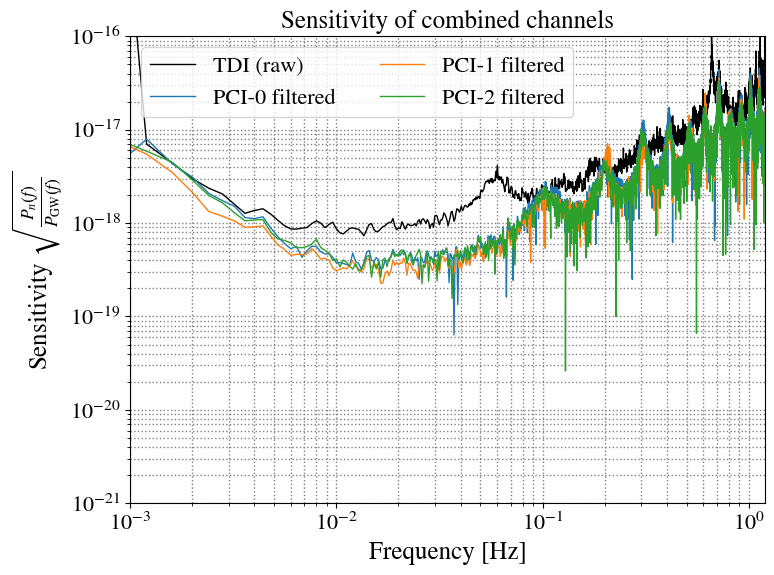

In [60]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (raw)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([1e-21, 1e-16])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

### PCI of single noise components

#### First we load the single noise data and generate the ys for those

In [58]:
# Get secondary noises
lockstr = 'locking_n1_12_baseline_noise_'

noises = ['test-mass', 'oms']

y_noise = {}

for nn in noises:
    noisepath = workdir + dtpath['noise']+ lockstr + nn + '_4Hz.h5'
    print(noisepath)
    
    data_noise = Data.from_instrument(noisepath)
    
    y_noise[nn] = build_data_vector(data_noise, skip=skip, dtype=np.float64)

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-19_13h05_locking_n1_12_baseline_noise_test-mass_4Hz.h5


You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-19_13h05_locking_n1_12_baseline_noise_oms_4Hz.h5


In [59]:
[y_noise[nn][:ns, :].T, y_full[:ns, :].T]

#[y_noise[nn][:ns, :].T, y_full[nn][:ns, :].T]

[array([[ 3.91972080e-19, -2.68413869e-19, -5.07439872e-20, ...,
          2.62699858e-19, -6.25070010e-20, -2.77331283e-19],
        [-6.95045476e-19,  7.45682411e-19, -4.19051417e-20, ...,
          1.25535009e-19,  1.06311158e-22,  2.40727816e-19],
        [-7.94442531e-20, -5.46528568e-20,  1.36253086e-19, ...,
          6.32698045e-20,  3.46920478e-21, -1.26271771e-19],
        [-6.87015798e-19,  4.41630159e-19,  9.49841255e-20, ...,
          7.46956662e-21, -9.22299727e-20,  3.38272343e-19],
        [-9.41834557e-20,  7.43894505e-20,  5.21661906e-21, ...,
          3.92118214e-20, -4.18630280e-20,  2.66886464e-20],
        [ 4.42480889e-19,  1.53912263e-19, -2.63528746e-19, ...,
          4.23461576e-19,  9.59561181e-20, -4.03960908e-19]],
       shape=(6, 172800)),
 array([[ 2.36789371e-13,  3.45532554e-14, -5.79191277e-14, ...,
          3.81376029e-14, -4.48951605e-14,  5.25240079e-13],
        [ 8.19541394e-14,  2.41011355e-13, -2.09498312e-13, ...,
         -1.03982210e-13,

In [60]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
labels = ['test-mass', 'oms', 'tm+oms', 'full']

colors = ['']
linestyles = ['']

## add y_full to y_noise in the pci_sens_list to have all of them
## change the labels and the colors

pci_sens_list += [
    ["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_noise[nn][:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(2,3) for nn in noises];
pci_sens_list += [["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_sec[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(2,3)];
pci_sens_list += [["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(2,3)];

single link data shape (6, 172710)
single link data shape (6, 172710)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 7.78978589e-49+0.00000000e+00j  3.03111261e-49+0.00000000e+00j
   -2.65749187e-48+0.00000000e+00j -7.78978756e-49+0.00000000e+00j
   -1.53495877e-47+0.00000000e+00j -3.19839017e-49+0.00000000e+00j]
  [ 3.03111261e-49-0.00000000e+00j  1.33499522e-49+0.00000000e+00j
   -1.85676400e-48+0.00000000e+00j -3.03111321e-49+0.00000000e+00j
   -7.93303886e-48+0.00000000e+00j -1.42965123e-49+0.00000000e+00j]
  [-2.65749187e-48-0.00000000e+00j -1.85676400e-48-0.00000000e+00j
    4.43549754e-46+0.00000000e+00j  2.65748897e-48+0.00000000e+00j
    4.32678143e-46+0.00000000e+00j  2.08848505e-48+0.00000000e+00j]
  [-7.78978756e-49-0.00000000e+00j -3.03111321e-49-0.00000000e+00j
    2.65748897e-48-0.00000000e+00j  7.78978923e-49+0.00000000e+00j
    1.53495882e-47+0.00000000e+00j  3.19839079e-49+0.00000000e+00j]
  [-1.53495877e-47-0.00000000e+00j -7.93303886e-48

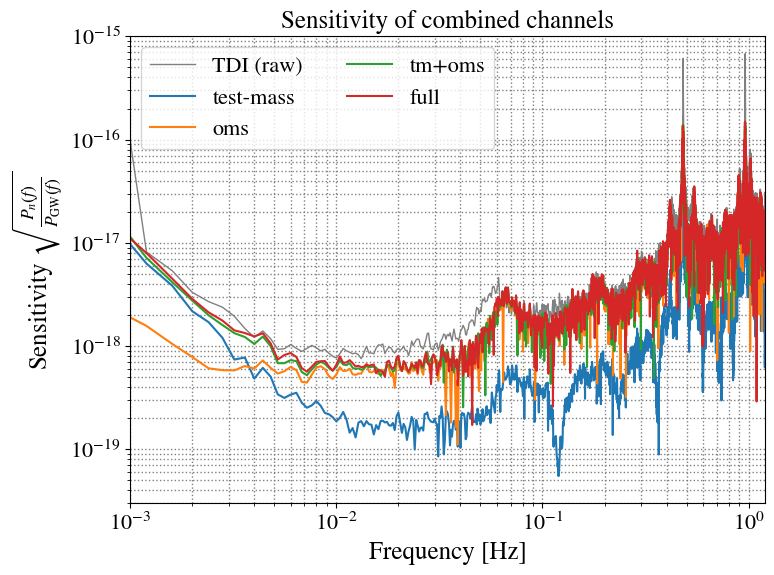

In [61]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (raw)',
            color='grey')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1.5, label=labels[j], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-20, 1e-15])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

In [52]:
data_noise

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-19_13h05_locking_n1_12_baseline_noise_test-mass_4Hz.h5


You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-19_13h05_locking_n1_12_baseline_noise_oms_4Hz.h5


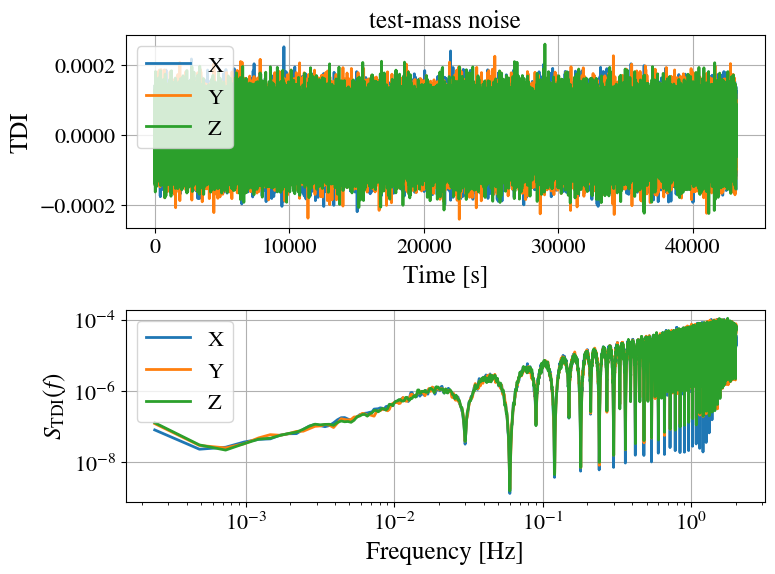

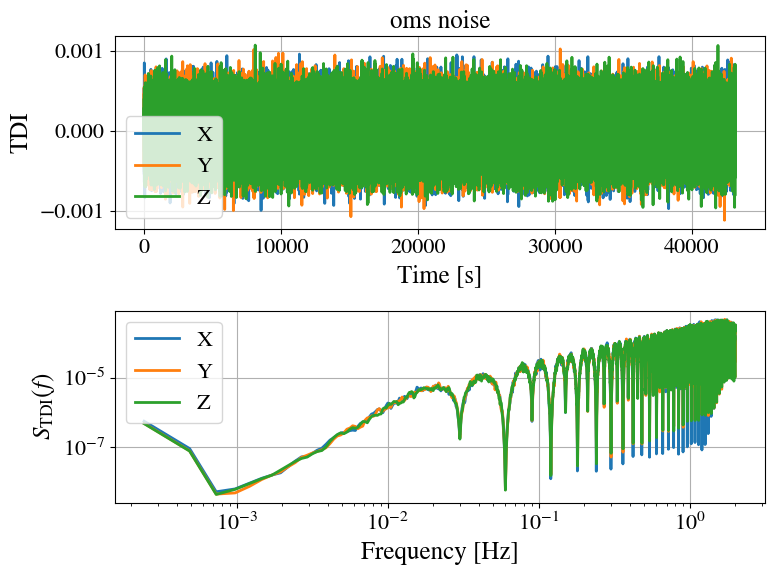

In [54]:
from pytdi import Data
from pytdi.michelson import X2, Y2, Z2

X, Y, Z = X2, Y2, Z2

for nn in noises:
    noisepath = workdir + dtpath['noise']+ lockstr + nn + '_4Hz.h5'
    print(noisepath)
    
    data_noise = Data.from_instrument(noisepath)

    # Build other 2.0 Michelson variables
    X_data = X.build(**data_noise.args)
    Y_data = Y.build(**data_noise.args)
    Z_data = Z.build(**data_noise.args)
    # Apply TDI 2.0
    x_noise = X_data(data_noise.measurements)
    y_noise = Y_data(data_noise.measurements)
    z_noise = Z_data(data_noise.measurements)

    tdi_times = np.arange(ns)*dt

    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex = False)
   # ax[0].set_title('{nn} noise'.format(nn=nn))
    ax[0].plot(tdi_times, x_noise[skip:skip+ns], label = 'X')
    ax[0].plot(tdi_times, y_noise[skip:skip+ns], label = 'Y')
    ax[0].plot(tdi_times, z_noise[skip:skip+ns], label = 'Z')
    ax[0].grid()
    ax[0].legend()
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('TDI')
    
    f, xpsd = signal.welch(x_noise[skip:skip+ns], **kwargs)
    f, ypsd = signal.welch(y_noise[skip:skip+ns], **kwargs)
    f, zpsd = signal.welch(z_noise[skip:skip+ns], **kwargs)
    
    ax[1].loglog(f[1:], np.sqrt(xpsd[1:]), label = 'X')
    ax[1].loglog(f[1:], np.sqrt(ypsd[1:]), label = 'Y')
    ax[1].loglog(f[1:], np.sqrt(zpsd[1:]), label = 'Z')
    ax[1].grid()
    ax[1].legend()
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].set_ylabel(r'$S_\text{TDI}(f)$') 

In [72]:
y_noise[nn].T[0]

array([-9.29957222e-21, -2.65217309e-20, -7.56437295e-20, ...,
       -5.02903750e-19, -5.73680645e-19, -5.29888901e-19], shape=(979200,))

In [70]:
nnpsd

array([[6.35561587e-40, 1.58098310e-39, 4.19452757e-41, 7.61606295e-40],
       [1.95609605e-40, 9.87337316e-40, 2.07387071e-39, 2.63567649e-39],
       [7.69241884e-41, 1.98958068e-39, 2.15776667e-39, 3.79225423e-40],
       ...,
       [1.74416883e-39, 7.68184046e-39, 2.82778790e-39, 4.81881833e-39],
       [3.09552696e-40, 9.15700578e-39, 9.52275071e-39, 1.05763137e-38],
       [5.85682650e-39, 2.05184895e-38, 7.49507102e-39, 4.98844594e-39]],
      shape=(172800, 4))

Text(0, 0.5, '$S_\\text{TDI}(f)$')

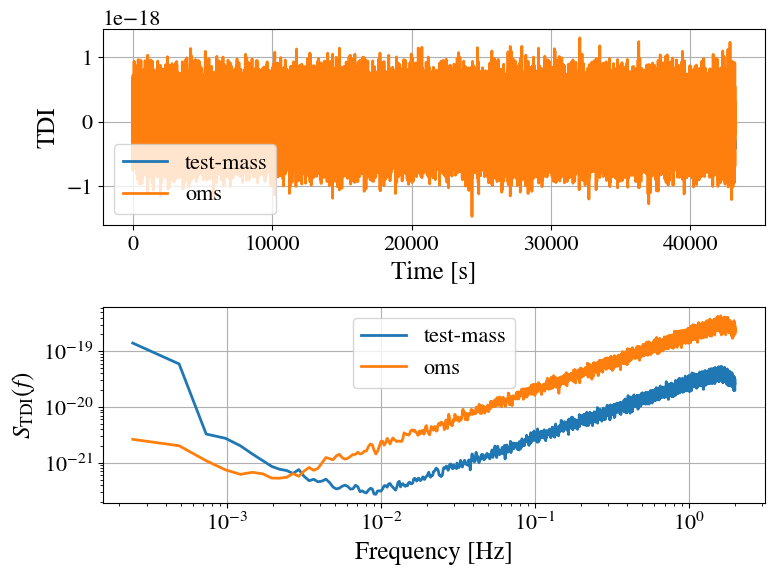

In [73]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex = False)
for nn in noises:

    tdi_times = np.arange(ns)*dt

    
   # ax[0].set_title('{nn} noise'.format(nn=nn))
    ax[0].plot(tdi_times, y_noise[nn].T[0][skip:skip+ns], label = nn)

    
    f, nnpsd = signal.welch(y_noise[nn].T[0][skip:skip+ns], **kwargs)
   
    ax[1].loglog(f[1:], np.sqrt(nnpsd[1:]), label = nn)


ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('TDI')

ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel(r'$S_\text{TDI}(f)$') 
